In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from pycbc.types import timeseries, frequencyseries
from calcwf import *

In [2]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096*2

In order to try and get the SVD to find the h-2 harmonic (very low frequency) (previously called h4 under old convention - referred to as h4 in this notebook), let's try with higher eccentricity and number of training waveforms. Increasing sample rate would likely also help, however we must be careful about the size of the array the SVD creates - this is likely to be tens if not hundreds of gigabytes.

In [3]:
# Generates n training waveforms equally spaced in mean anomaly
def gen_training_wfs(f_low, e, M, q, n, sample_rate, approximant):

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    training_wfs = []
    # Generate all training waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)

        # Trim waveform to same size as first (shortest), and corrects phase
        if i > 0:
            h = trim_wf(h, training_wfs[0])
            overlap = overlap_cplx_wfs(h, training_wfs[0], f_low)
            phase_angle = +np.angle(overlap)/2
            h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=phase_angle)
            h = trim_wf(h, training_wfs[0])
            h.resize(ceiltwo(max(len(h), len(training_wfs[0]))))
        else:
            h.resize(ceiltwo(len(h)))   
        
        training_wfs.append(h)

        # Progress bar
        print(f'\r{i+1} done out of {n}.', end='')

    return training_wfs

In [4]:
training_wfs = gen_training_wfs(f_low, e, chirp2total(chirp, q), q, 500, sample_rate, 'TEOBResumS')

500 done out of 500.

In [5]:
# Whitens waveforms
def whiten_wfs(wfs, f_low):

    # Generate psd
    psd = gen_psd(wfs[0], f_low)
    delta_f = psd.delta_f

    # Set zero values to 1 (effectively infinity)
    psd = np.array(psd)
    psd[psd==0]=1
    psd = frequencyseries.FrequencySeries(psd, delta_f)

    # Whiten each wf
    whiten = []
    for wf in wfs:
        hp = (wf.real().to_frequencyseries() / psd ** 0.5).to_timeseries()
        hc = (-wf.imag().to_frequencyseries() / psd ** 0.5).to_timeseries()
        whiten.append(hp-1j*hc)

    return whiten

In [6]:
white_training_wfs = whiten_wfs(training_wfs, 10)

In [7]:
# Convert training wf data to np array in right shape/form and calculate svd
start = time.time()
X = np.array(training_wfs).T
means = X.mean(axis=0)
stds = X.std(axis=0)
U, S, Vh = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

Time taken: 659.1242549419403 seconds


In [8]:
V = Vh.T.conj()

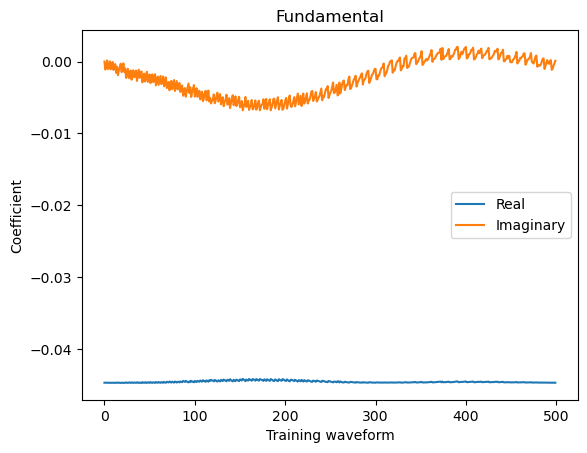

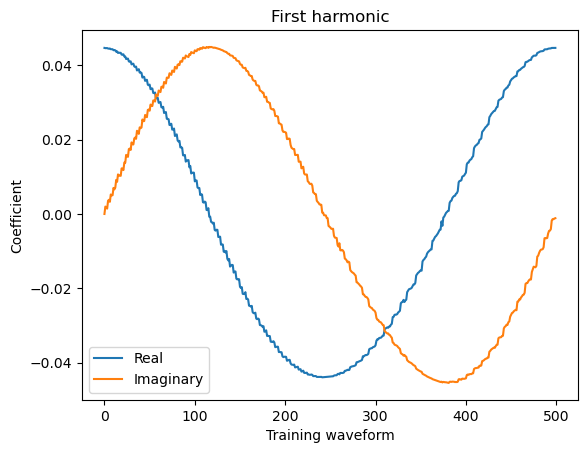

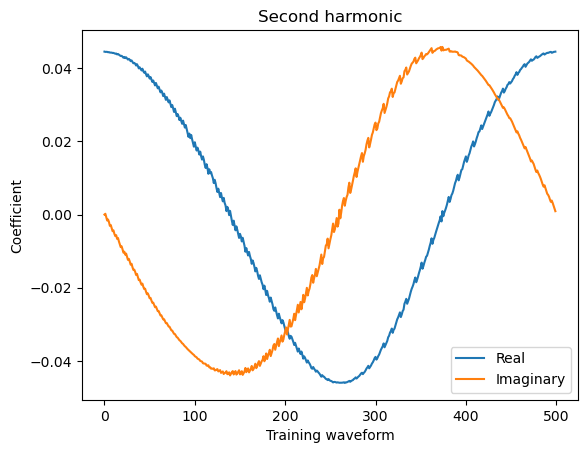

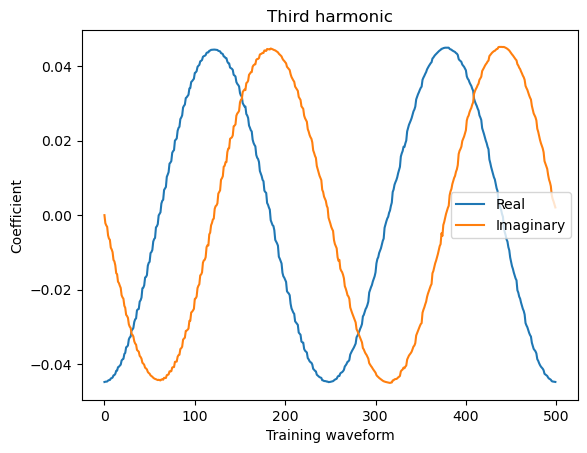

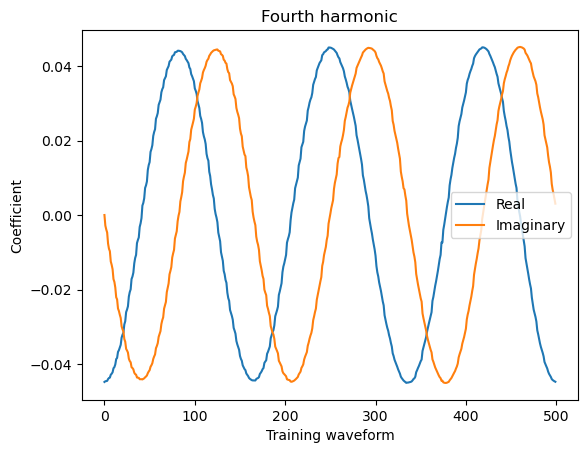

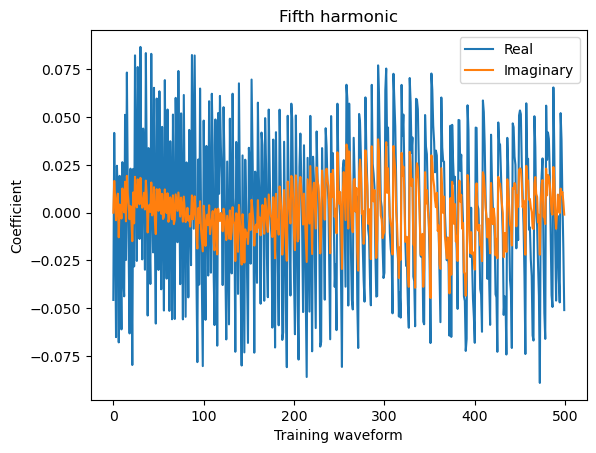

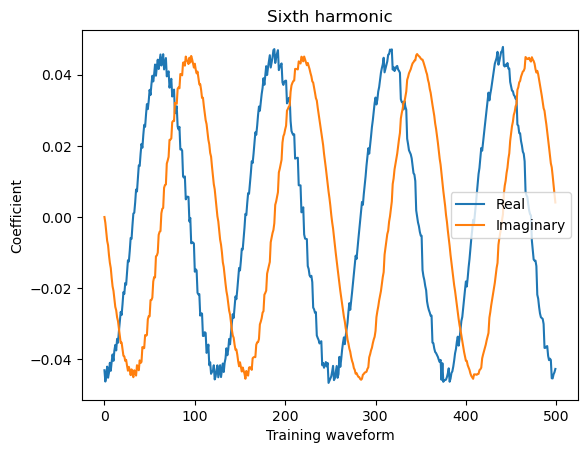

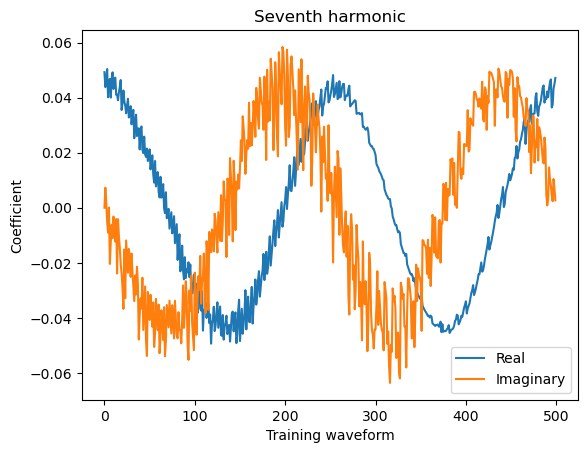

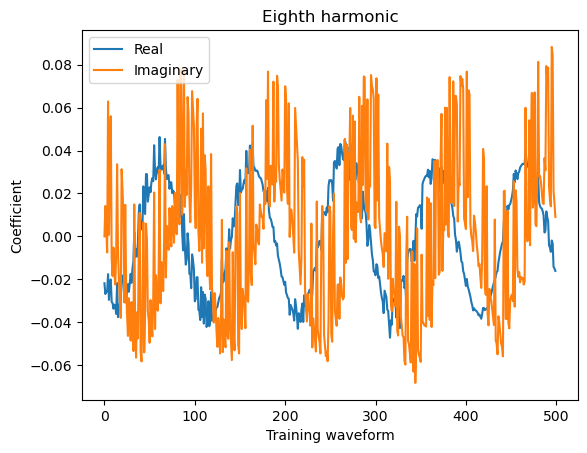

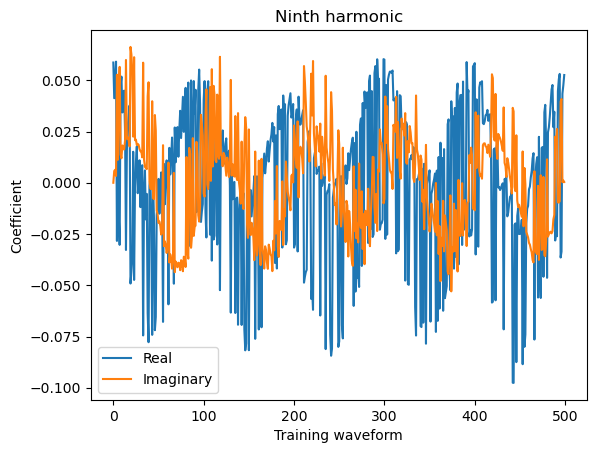

In [9]:
titles = ['Fundamental', 'First harmonic', 'Second harmonic', 'Third harmonic', 'Fourth harmonic', 'Fifth harmonic', 'Sixth harmonic', 'Seventh harmonic', 'Eighth harmonic', 'Ninth harmonic']
for i in range(10):
    plt.plot(np.arange(len(V.T[i])), np.real(V.T[i]), label='Real')
    plt.plot(np.arange(len(V.T[i])), np.imag(V.T[i]), label='Imaginary')
    plt.title(titles[i])
    plt.ylabel('Coefficient')
    plt.xlabel('Training waveform')
    plt.legend()
    plt.show()

Seems here that the 'seventh harmonic' it recovers is actually what we expect h4 to look like.